## Imports

In [1]:
!nvidia-smi

Sat Apr 17 14:55:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
from PIL import Image

In [3]:
device = torch.device("cuda")

In [4]:
!wget -O content.jpg https://cdn.sozvezdie-tour.ru/images/uploadedfiles/fed20ae1-f278-4db2-b414-63b6dd6142de.jpg
!wget -O style.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

--2021-04-17 14:55:28--  https://cdn.sozvezdie-tour.ru/images/uploadedfiles/fed20ae1-f278-4db2-b414-63b6dd6142de.jpg
Resolving cdn.sozvezdie-tour.ru (cdn.sozvezdie-tour.ru)... 185.10.185.115
Connecting to cdn.sozvezdie-tour.ru (cdn.sozvezdie-tour.ru)|185.10.185.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112495 (110K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>] 109.86K   326KB/s    in 0.3s    

2021-04-17 14:55:29 (326 KB/s) - ‘content.jpg’ saved [112495/112495]

--2021-04-17 14:55:29--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540189 (528K) [image/jpeg]
Sa

In [5]:
imsize = 512

transform = transforms.Compose([transforms.Resize(imsize),
                             transforms.CenterCrop((imsize, imsize)),
                             transforms.ToTensor()])

def load(img_name):
    img = Image.open(img_name)
    img = transform(img).unsqueeze(0)
    return img.to(device, torch.float)


In [6]:
style_img = load("style.jpg")
content_img = load("content.jpg")

In [7]:
style_img.size()

torch.Size([1, 3, 512, 512])

In [8]:
content_img.size()

torch.Size([1, 3, 512, 512])

In [9]:
def show(img):
  img = img.transpose(1, 2).transpose(2, 3).cpu().numpy()
  img = img.squeeze()
  img = (img * 255).astype('uint8')
  plt.figure(figsize=(6, 6))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

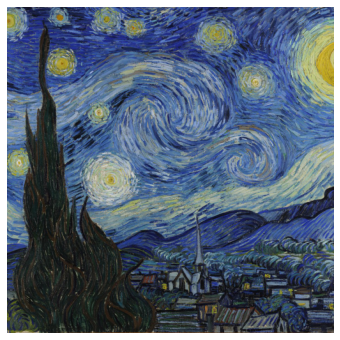

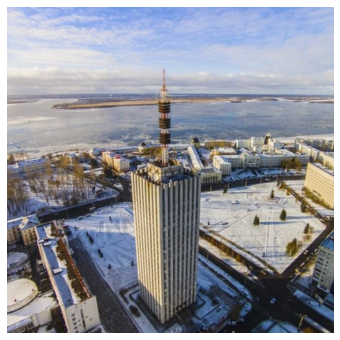

In [10]:
show(style_img)
show(content_img)

In [11]:
# load pretrained vgg feature extractor

vgg_model = models.vgg19(pretrained=True).features.to(device).eval()

## Loss

In [12]:
# Content loss

class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target.detach())
        return input

In [13]:
# Style loss

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self._gram_matrix(target_feature)

    def _gram_matrix(self, input):
        _, channels, h, w = input.size()  
        features = input.view(channels, h * w)
        gram = torch.mm(features, features.t()).div(channels * h * w)
        return gram

    def forward(self, input):
        gram = self._gram_matrix(input)
        self.loss = F.mse_loss(gram, self.target.detach())
        return input

## Load pretrained VGG feature extractor

In [44]:
def get_model(cnn_model, 
             style_img, 
             content_img):
    
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    
    content_idx = ['4']
    style_idx = ['1', '2', '3', '4', '5']

    cnn = copy.deepcopy(cnn_model)

    content_losses = []
    style_losses = []

    model = nn.Sequential()

    i = 0  

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        if str(i) in content_idx + style_idx:
            model.add_module(name, layer)
        
        if name in content_layers:       
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [45]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [1]:
def style_transfer(cnn, 
                   content_img, 
                   style_img, 
                   input_img, 
                   iters=100, 
                   alpha=1, 
                   betta=1e6):

    model, style_losses, content_losses = get_model(cnn, style_img, content_img)

    optimizer = get_input_optimizer(input_img)

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    normalize = transforms.Normalize(mean, std)

    iteration = 0
    while iteration < iters:

        def closure():
            nonlocal iteration
            input_img_ = normalize(input_img)
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()

            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss

            for cl in content_losses:
                content_score += cl.loss

            content_score *= alpha
            style_score *= betta

            loss = style_score + content_score
            loss.backward()

            iteration += 1
            if iteration % 20 == 0:
                print(f"iter: {iteration}")
                print('Style Loss : {:4f}'.format(style_score.item()))
                print('Content Loss: {:4f}'.format(content_score.item()))
                print()
            return loss

        optimizer.step(closure)
        # optimizer.step()

    input_img.data.clamp_(0, 1)

    return input_img

In [2]:
output = style_transfer(vgg_model, content_img, style_img, content_img.clone())

NameError: ignored

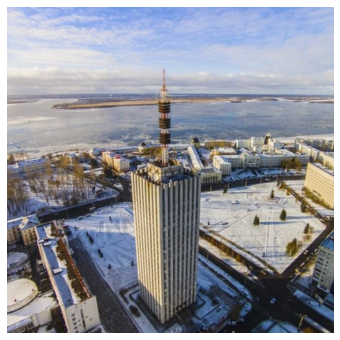

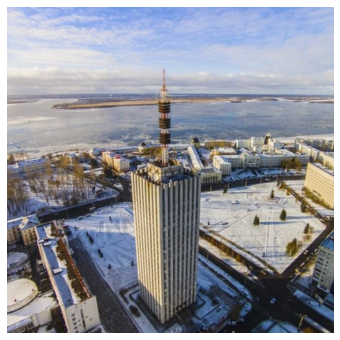

In [54]:
show(output.detach())
show(content_img)